In [1]:
# ==== TEST & EVALUATE SAVED MODEL USING YOUR TEST GENERATOR ====
import numpy as np
import tensorflow as tf
from keras.models import load_model
from sklearn.metrics import (
    classification_report, confusion_matrix, ConfusionMatrixDisplay,
    roc_auc_score, accuracy_score
)
import matplotlib.pyplot as plt
import preprocess

2025-09-20 03:30:48.331914: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-09-20 03:30:48.433495: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-09-20 03:30:52.873382: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-09-20 03:31:08.584788: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
folder_path = "../../../Data/images/"
batch_size = 64
picture_size = 48



# 1) Build test generator (uses your function)
test_ds = preprocess.get_test_data_gen(folder_path, picture_size=picture_size, batch_size=batch_size)

# Derive class names in index order
# ImageDataGenerator maps class_indices (dict label->idx); we want list ordered by idx
idx_to_class = {v:k for k, v in test_ds.class_indices.items()}
class_names = [idx_to_class[i] for i in range(len(idx_to_class))]

# 2) Load saved model
saved = load_model(f"models/model_model.h5")


Found 7066 images belonging to 7 classes.


2025-09-20 03:33:59.063308: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


/opt/conda/envs/ml-env/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Test Loss: 1.021702 | Test Accuracy: 0.607699

Detailed classification report:
              precision    recall  f1-score   support

       angry     0.5287    0.4792    0.5027       960
     disgust     0.5714    0.2162    0.3137       111
        fear     0.6233    0.1788    0.2779      1018
       happy     0.8221    0.8608    0.8410      1825
     neutral     0.4645    0.7377    0.5701      1216
         sad     0.4723    0.4723    0.4723      1139
    surprise     0.7060    0.7804    0.7414       797

    accuracy                         0.6077      7066
   macro avg     0.5983    0.5322    0.5313      7066
weighted avg     0.6187    0.6077    0.5883      7066



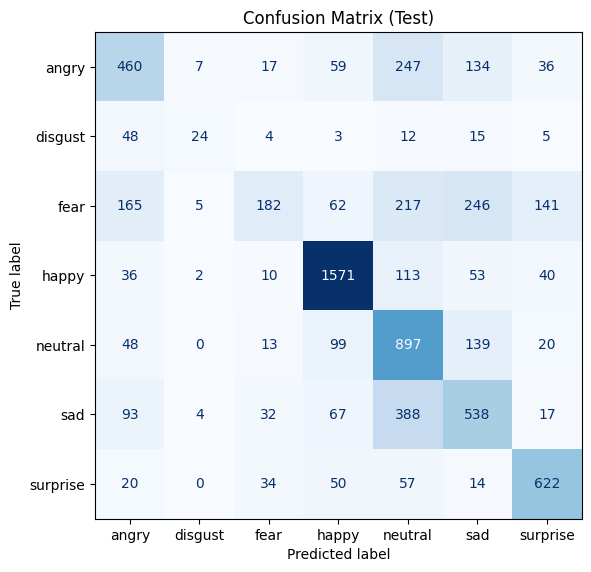

Macro ROC-AUC: 0.894273
Top-3 Accuracy: 0.898811 | Top-5 Accuracy: 0.986838


In [3]:


# 3) Quick eval (loss/acc) using Keras
loss, acc = saved.evaluate(test_ds, verbose=0)
print(f"Test Loss: {loss:.6f} | Test Accuracy: {acc:.6f}")

# 4) Collect all test batches (numpy already)
#    test_ds.labels are integer class ids; test_ds.classes is an alias
y_true_int = test_ds.classes.astype(int)
# If categorical, also make one-hot for ROC-AUC / top-k
y_true_1h = tf.keras.utils.to_categorical(y_true_int, num_classes=len(class_names))

# Predict probabilities for all samples
y_prob = saved.predict(test_ds, verbose=0)
y_pred_int = np.argmax(y_prob, axis=1)

# 5) Metrics
print("\nDetailed classification report:")
print(classification_report(y_true_int, y_pred_int, target_names=class_names, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true_int, y_pred_int, labels=range(len(class_names)))
fig, ax = plt.subplots(figsize=(6,6))
ConfusionMatrixDisplay(cm, display_labels=class_names).plot(ax=ax, cmap="Blues", colorbar=False)
plt.title("Confusion Matrix (Test)")
plt.tight_layout()
plt.show()

# Macro ROC-AUC (one-vs-rest) — works with one-hot labels
try:
    auc_macro = roc_auc_score(y_true_1h, y_prob, multi_class="ovr", average="macro")
    print(f"Macro ROC-AUC: {auc_macro:.6f}")
except Exception as e:
    print("ROC-AUC not available:", e)

# Top-k accuracy (Top-3 / Top-5)
top3 = tf.keras.metrics.top_k_categorical_accuracy(y_true_1h, tf.convert_to_tensor(y_prob), k=3).numpy().mean()
top5 = tf.keras.metrics.top_k_categorical_accuracy(y_true_1h, tf.convert_to_tensor(y_prob), k=5).numpy().mean()
print(f"Top-3 Accuracy: {top3:.6f} | Top-5 Accuracy: {top5:.6f}")


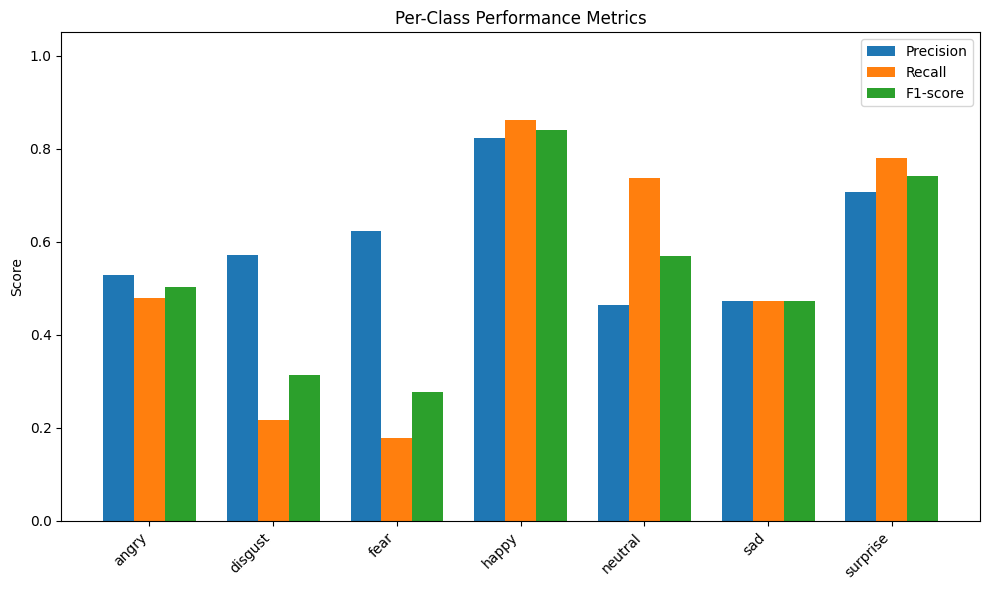

In [4]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate per-class metrics
prec, rec, f1, _ = precision_recall_fscore_support(
    y_true_int, y_pred_int, labels=range(len(class_names))
)

x = np.arange(len(class_names))  # class indices
width = 0.25

fig, ax = plt.subplots(figsize=(10, 6))

ax.bar(x - width, prec, width, label="Precision")
ax.bar(x, rec, width, label="Recall")
ax.bar(x + width, f1, width, label="F1-score")

ax.set_xticks(x)
ax.set_xticklabels(class_names, rotation=45, ha="right")
ax.set_ylabel("Score")
ax.set_ylim(0, 1.05)
ax.set_title("Per-Class Performance Metrics")
ax.legend()
plt.tight_layout()
plt.show()

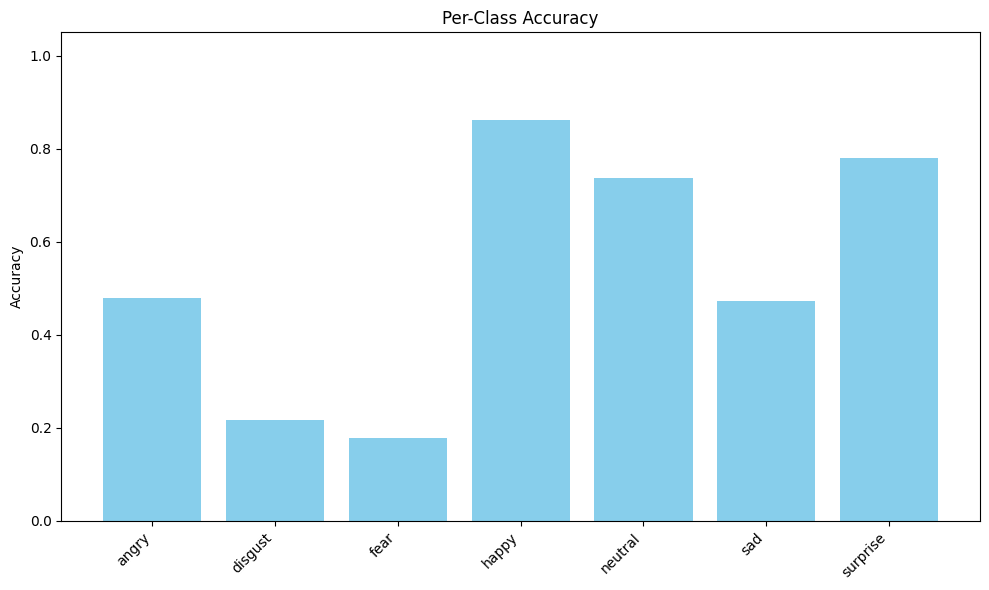

In [5]:
class_acc = []
for i, cls in enumerate(class_names):
    # all samples of this class
    idx = np.where(y_true_int == i)[0]
    if len(idx) > 0:
        acc = np.mean(y_pred_int[idx] == y_true_int[idx])
    else:
        acc = np.nan  # in case a class has no samples
    class_acc.append(acc)

# Plot
fig, ax = plt.subplots(figsize=(10,6))
ax.bar(class_names, class_acc, color="skyblue")
ax.set_ylim(0, 1.05)
ax.set_ylabel("Accuracy")
ax.set_title("Per-Class Accuracy")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

Happy class is the best perfoming class
